# Project Introduction - Customer Segmentation (Part 2)
The goal of this project is to analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population with the aim of understanding which segment of the population the company should aim for in its next mail campaign. 

The project is divided into __three main parts__:
1. The first part will be decicated to the data preparation: This data is high-dimensional and has a high degree of missing values, therefore it is important to understand and clean the data.
2. In this section the customers will be segmented using a __unsupervised learning approach__ and using the customer's data against the general population's data. Not only is the goal to understand which groups of customers are more interesting for the campaign but also to select the most important features.
3. Using the information gained a __supervised learning algorithm__ will be used for a classification task to predict which recipients are most likely to become a customer for the mail-order company.

__Note__: This notebook handles part 2. The first part of the data cleaning process can be found in this notebook [here](https://github.com/bruno-f7s/portfolio/blob/main/arvarto-customer-segmentation/01-data-cleaning.ipynb).

In [1]:
# import libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from joblib import dump

# magic word for producing visualizations in notebook
%matplotlib inline

# configurations
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.set_option('display.max_colwidth', None)

# PART 2: Customer Segmentation (Unsupervised Learning)
In this section we will try to understand which parts of the customers' dataset are overrepresented or underrepresented in the population dataset with the goal of identifying the types of customers the company should target. This will be done by clustering both datasets and comparing the distributions of the clusters. Since we have almost 50 columns, it is a good idea to reduce the complexity of the problem to avoid redundancy and overfitting issues.

The approach looks like this:
1.	Reduce the dimensionality using PCA to a certain `n` number of components that explain a reasonable amount of the variance for each type of columns.
2.	Find the top 20 features which have the most impact on the total components so we can use them to understand customer segments.
3.	Find a `k` number of clusters for the `n` components of the population data using common methods of analysis and use the best fitting `k` to cluster the customer dataset.
4.	Compare the distribution of the clusters for the population with the customers’ dataset and see which ones are overrepresented or underrepresented.
5.	Make a centroid analysis of the clusters using for top 20 features to understand the types of customers the company should target or avoid.
6.  Analyze the results and deploy the clustering model to use in part 3.


In [ ]:
# Load the cleaned data for the customer segmentation part
population_df = pd.read_csv('data\\Cleaned_Udacity_AZDIAS_052018.csv', sep=';')
customers_df = pd.read_csv('data\\Cleaned_Udacity_CUSTOMERS_052018.csv', sep=';')

# Load the attributes df
attributes_df = pd.read_excel('data-dictionary\\DIAS Attributes - Values 2017.xlsx', usecols = [1,2,3,4], skiprows=1)
attributes_df = attributes_df.fillna(method="ffill")
attributes_nms = list(attributes_df["Attribute"].unique())

# Load the attributes df
info_level_df = pd.read_excel('data-dictionary\\DIAS Information Levels - Attributes 2017.xlsx', usecols = [1,2], skiprows=1)
info_level_df = info_level_df.fillna(method="ffill")

In [ ]:
population_df.shape

## 1.1 Dimensionality Reduction
We will use PCA and plot the cumulative explained variance ratio to understand which components explain a significant amount of the variance while reducing the complexity of the data. Since this is a complex dataset we can use the different levels of information for the groups of columns using the file `DIAS Information Levels - Values 2017.xlsx`.

Because we want to understand customer segments we can adjust threshold for explainability to the information level. For instance, we may want to capture more information about personal data rather than about the number of cars owned in a particular residence area. This should be done together with a domain expert but I decided to set the thresholds like this:

| Information Level   | Threshold | Weight |
|---------------------|-----------|--------|
| Person              | 80%       | 26%    |
| Household           | 60%       | 19%    |
| Microcell           | 50%       | 16%    |
| PLZ8                | 50%       | 16%    |
| Rest                | 70%       | 23%    |

### Population dataset

In [ ]:
population_cols = population_df.columns.copy()

In [ ]:
# Get list of columns for information level: Household
info_level_hh_cols = info_level_df[info_level_df["Information level"].isin(["Household","Building"])]["Attribute"].tolist()
hh_cols = [col for col in info_level_hh_cols if col in population_cols]
additional_hh_cols = [col for col in population_cols if re.search("D19_|WOHNLAGE_|GEBAEUDETYP_|MIN_GEBAEUDEJAHR_RTV17", col)]
hh_cols = list(set(hh_cols + additional_hh_cols))
population_cols = list(set(population_cols) - set(hh_cols))
print(hh_cols)

In [ ]:
# Get list of columns for information level: Person
info_level_person_cols = info_level_df[info_level_df["Information level"] == "Person"]["Attribute"].tolist()
person_cols = [col for col in info_level_person_cols if col in population_cols]
additional_person_cols = [col for col in population_cols if re.search("LP_|TYP_|EINGEZOGENAM_HH_JAHR_RTV17|KZ_", col)]
person_cols = list(set(person_cols + additional_person_cols))
population_cols = list(set(population_cols) - set(person_cols))
print(person_cols)

In [ ]:
# Get list of columns for information level: Microcell
info_level_microcell_cols = info_level_df[info_level_df["Information level"] == "Microcell (RR3_ID)"]["Attribute"].tolist()
microcell_cols = [col for col in info_level_microcell_cols if col in population_cols]
additional_microcell_cols = [col for col in population_cols if "KBA05_" in col]
microcell_cols = list(set(microcell_cols + additional_microcell_cols))
population_cols = list(set(population_cols) - set(microcell_cols))
print(microcell_cols)

In [ ]:
# Get list of columns for information level: PLZ8
info_level_PLZ8_cols = info_level_df[info_level_df["Information level"] == "PLZ8"]["Attribute"].tolist()
PLZ8_cols = [col for col in info_level_PLZ8_cols if col in population_cols]
additional_PLZ8_cols = [col for col in population_cols if "PLZ8_" in col]
PLZ8_cols = list(set(PLZ8_cols + additional_PLZ8_cols))
population_cols = list(set(population_cols) - set(PLZ8_cols))
print(PLZ8_cols)

In [ ]:
# Get list of columns for information level: Rest
rest_cols = population_cols.copy()
print(rest_cols)

In [ ]:
def plot_pca(df, column_list, df_name, threshhold):
    """
    This function plots the cumulative explained variance using PCA for a particular threshold of explained variance. 
    It takes in as arguments a dataset, the list of columns, the name of the dataset and a threshhold to find the number of components for that explained variance.
    """
    # Step 1: Select the data
    df = df[column_list]
    
    # Step 2: Fit a standard PCA to find the n components
    pca = PCA(random_state=101)
    pca_result = pca.fit_transform(df)

    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    n_components_for_threshhold = np.where(cum_explained_variance >= threshhold)[0][0]
    
    # Step 3 - Plot the Cumulative Explained Variances
    plt.figure(figsize=(16,6))

    plt.subplot(1, 2, 2)
    plt.plot(range(len(explained_variance)), cum_explained_variance)
    plt.ylabel('Cumulative explained variance ratio')
    plt.xlabel('Number of components')
    plt.title(f'Cumulative Explained Variance Plot for the {df_name}')
    plt.axhline(y=threshhold, color='grey', linestyle='--', label=f'Threshold at {threshhold}') 

    plt.annotate(text = f"{n_components_for_threshhold} components explain\n{round(threshhold*100)}% of the variance.",
                 xy = (n_components_for_threshhold, threshhold),
                 xytext = (n_components_for_threshhold, threshhold-0.1),
                 arrowprops=dict(arrowstyle='->'))

    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show(); 

In [ ]:
# Scale the population dataset before applying PCA
sc = StandardScaler()
scaled_population_array = sc.fit_transform(population_df)
scaled_population_df = pd.DataFrame(scaled_population_array, columns=population_df.columns)
scaled_population_df.head()

__Information level__: Person

In [ ]:
plot_pca(scaled_population_df, person_cols, "Person Columns", 0.8)

__Information level__: Household

In [ ]:
plot_pca(scaled_population_df, hh_cols, "Household Columns", 0.6)

__Information level__: Microcell

In [ ]:
plot_pca(scaled_population_df, microcell_cols, "Microcell Columns", 0.5)

__Information level__: PLZ8

In [ ]:
plot_pca(scaled_population_df, PLZ8_cols, "PLZ8 Columns", 0.5)

__Information level__: Rest

In [ ]:
plot_pca(scaled_population_df, rest_cols, "Rest Columns", 0.7)

__Analysis__: Based on the graphics above we can reduce the initial 499 columns to __132 components__ and still keep a big part of the variance for the parts that interest us the most.

 The next step now would be to understand which features are being more important to explain variance of the data. One way to do this would be to look at the first principal component and then the second, which is something that we see a lot in literature. However, these first components would not be enough to capture the full picture.

For this scenario, I decided to have a final list of __20 most influential features__ to use for the customer segmentation analysis. The idea was to get the top `m` most influential features for each group of columns in order to create this final list where `m` is a number that corresponds to the weights assigned to each group - for example since the Person group accounts for 26% of the importance then the 5 features from this group would be included in the top 20.

The way to find the most important features for each group can look like this: For each principal component of a number `n` of principal components we take the top 10 most influential and add them to a list. Each time the same feature appears it gets added by 1. At the end of the `nth` principal component we select the corresponding number `m` of features and include them to the final top 20 list. Finding the ideal value of `n` principal components can be done for example by applying an elbow method of the Scree Plot using the explained variance ratio.

In [ ]:
# Fit the PCA with identified numbers of components for each information level

# Information level: Person
pca_person = PCA(n_components=66, random_state=101)
pca_person_array = pca_person.fit_transform(scaled_population_df[person_cols])

explained_variance_person = pca_person.explained_variance_ratio_

#-----------------------------------------------------------------------------

# Information level: Household
pca_hh = PCA(n_components=25, random_state=101)
pca_hh_array = pca_hh.fit_transform(scaled_population_df[hh_cols])

explained_variance_hh = pca_hh.explained_variance_ratio_

#-----------------------------------------------------------------------------

# Information level: Microcell
pca_microcell = PCA(n_components=4, random_state=101)
pca_microcell_array = pca_microcell.fit_transform(scaled_population_df[microcell_cols])

explained_variance_microcell = pca_microcell.explained_variance_ratio_

#-----------------------------------------------------------------------------

# Information level: PLZ8
pca_PLZ8 = PCA(n_components=10, random_state=101)
pca_PLZ8_array = pca_PLZ8.fit_transform(scaled_population_df[PLZ8_cols])

explained_variance_PLZ8 = pca_PLZ8.explained_variance_ratio_

#-----------------------------------------------------------------------------

# Information level: Rest
pca_rest = PCA(n_components=27, random_state=101)
pca_rest_array = pca_rest.fit_transform(scaled_population_df[rest_cols])

explained_variance_rest = pca_rest.explained_variance_ratio_

In [ ]:
def plot_scree_plot(explained_variance, information_level, component_number):
    plt.figure(figsize=(20,5))
    
    # Adjust the x-values to start from 1
    x_values = range(1, len(explained_variance) + 1)
    
    plt.plot(x_values, explained_variance, alpha=0.5, label='individual explained variance', marker='o')
 
    # Adjust the x-value for the "elbow" point
    plt.plot(component_number, explained_variance[component_number-1], 'ro', label=f"Elbow at the principal component {component_number}")

    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.title(f'Scree Plot for the {information_level} columns')
    plt.legend()

In [ ]:
plot_scree_plot(explained_variance_person, "Person", 5)

In [ ]:
plot_scree_plot(explained_variance_hh, "Household", 2)

In [ ]:
plot_scree_plot(explained_variance_microcell, "Microcell", 2)

Since the elbow is not that pronounced we can just simply use 1 principal component for the feature importance analysis

In [ ]:
plot_scree_plot(explained_variance_PLZ8, "PLZ8", 5)

In [ ]:
plot_scree_plot(explained_variance_rest, "REST", 3)

In [ ]:
def get_top_features(pca, n_components, information_level_cols):
    """
    It prints the most influential features of the list of columns 
    for a PCA instance for a specific number of components based on the information level.
    """
    
    # Instantiate an array of zeros for the number of features 
    feature_counts = np.zeros(len(information_level_cols))

    # For each component of the chosen principal components find the top 10 most influential features and add 1 to the feature counts
    for component in pca.components_[:n_components]:
        top_indices = np.abs(component).argsort()[-10:][::-1]
        feature_counts[top_indices] += 1

    # Create a DataFrame with the feature counts
    feature_counts_df = pd.DataFrame({
        'Feature': information_level_cols,
        'Counts': feature_counts
    })

    # Find the top features
    top_features = feature_counts_df[feature_counts_df["Counts"] > 0].sort_values("Counts", ascending=False)
    
    print(top_features)

In [ ]:
# get the most important features for the information level: Person
get_top_features(pca_person, 5, person_cols)

In [ ]:
# get the most important features for the information level: Household
get_top_features(pca_hh, 2, hh_cols)

In [ ]:
# get the most important features for the information level: Microcell
get_top_features(pca_microcell, 1, microcell_cols)

In [ ]:
# get the most important features for the information level: PLZ8
get_top_features(pca_PLZ8, 5, PLZ8_cols)

In [ ]:
# get the most important features for the information level: Rest
get_top_features(pca_rest, 3, rest_cols)

Now that we know which columns are more important for the principal components of each information level group we can now create the final list of top 20 features using the weights determined above. The table below illustrates how many columns from each information level group should be taken:

| Information Level | Number of features |
|-------------------|--------------------|
| Person            | 7                  |
| Household         | 4                  |
| Microcell         | 2                  |
| PLZ8              | 2                  |
| Rest              | 5                  |

In some cases, if there is a tie in the most important features the feature will be decided based on the personal assumption of being more important.

Based on this analysis these are the features to be considered for the customer segmentation analysis when we cluster the data:
__Person__
- `PRAEGENDE_JUGENDJAHRE`: dominating movement in the person's youth (avantgarde or mainstream)
- `FINANZ_HAUSBAUER`: financial typology: main focus is the own house
- `LP_STATUS_FEIN`: LP_STATUS_FEIN
- `GREEN_AVANTGARDE`: Green avantgarde: the environmental sustainability is the dominating movement in the youth of these consumers
- `SEMIO_ERL`: affinity indicating in what way the person is eventful orientated
- `FINANZ_SPARER`: financial typology: money saver
- `LP_FAMILIE_FEIN_1.0`: familytyp fine: single

__Household__
- `HH_EINKOMMEN_SCORE`: estimated household net income 
- `D19_GESAMT_OFFLINE_DATUM`: actuality of the last transaction with the complete file OFFLINE
- `D19_GESAMT_ONLINE_DATUM`: actuality of the last transaction with the complete file ONLINE
- `D19_KONSUMTYP_MAX`: consumption type 

__Microcell  & PLZ8__
- `KBA13_AUTOQUOTE`: share of cars per household within the PLZ8
- `KBA05_KRSKLEIN`: share of small cars (referred to the county average)
- `PLZ8_ANTG1`: number of 1-2 family houses in the PLZ8
- `KBA13_ALTERHALTER_60`: share of car owners between 46 and 60 within the PLZ8

__Rest__
- `INNENSTADT`: distance to the city centre
- `CAMEO_DEUG_2015`: CAMEO classification 2015 - Uppergroup
- `KKK`: purchasing power
- `CAMEO_INTL_2015_51`: CAMEO international typology: Poorer Households-Pre-Family Couples & Singles
- `CAMEO_INTL_2015_14`: CAMEO international typology: Wealthy Households-Older Families &  Mature Couples
- `ORTSGR_KLS9`: size of the community

Finally, we can merge all components together into one single object so we can find the best number of clusters.

In [ ]:
pca_population = np.hstack((pca_person_array, pca_hh_array, pca_microcell_array, pca_PLZ8_array, pca_rest_array))
pca_population.shape

### Customers dataset
Here we can apply the same dimensionality reduction as before using the same models as for the population to keep the same characteristics of the data.

In [ ]:
# Scale the data using the same scaler from the population dataset
scaled_customers_array = sc.transform(customers_df)
scaled_customers_df = pd.DataFrame(scaled_customers_array, columns=customers_df.columns)

# Fit the PCA using the same models from the population dataset
pca_c_person_array = pca_person.transform(scaled_customers_df[person_cols])
pca_c_hh_array = pca_hh.transform(scaled_customers_df[hh_cols])
pca_c_microcell_array = pca_microcell.transform(scaled_customers_df[microcell_cols])
pca_c_PLZ8_array = pca_PLZ8.transform(scaled_customers_df[PLZ8_cols])
pca_c_rest_array = pca_rest.transform(scaled_customers_df[rest_cols])

pca_customers = np.hstack((pca_c_person_array, pca_c_hh_array, pca_c_microcell_array, pca_c_PLZ8_array, pca_c_rest_array))
pca_customers.shape

## 1.2. Clustering
In this section we will continue using the results of the PCA for the population dataset to find the number of clusters that are able to segment the data the best as possible. Afterwards, we will fit the same clusters onto the customers' dataset and compare their distributions. This will help determine which groups of customers should be target primarily. Once we have our clusters chosen, the final step is to evaluate their characteristics using a cluster centroid analysis for the selection of features we done previously.

### 1.2.1 Find best number of clusters
To find the best number of clusters (K) we can use the population dataset and combine different clustering evaluation methods:
- Elbow method
- Silloutte Scores
- Silloutte Plot

In [ ]:
max_clusters = 20
sum_of_squared_distances = []
silhouette_scores = []

for n_clusters in range(2, max_clusters+1):
    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=101)
    
    # Fit on the population dataset
    clusterer.fit(pca_population)
    
    # Predict on the population dataset
    cluster_labels = clusterer.predict(pca_population)
    
    # Sum of squared distances for the elbow method
    sum_of_squared_distances.append(clusterer.inertia_)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pca_population, cluster_labels)
    silhouette_scores.append(silhouette_avg)
        
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )

    # create the silhouette plots only until 10 clusters
    if n_clusters <= 10:
        # Create a subplot with 1 row and 2 columns
        fig, ax = plt.subplots()
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        ax.set_xlim([-0.1, 1])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(pca_population) + (n_clusters + 1) * 10])


        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(pca_population, cluster_labels)
        y_lower = 10

        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title(f"Silhouette plot for {n_clusters} clusters.")
        ax.set_xlabel("Silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.show()

In [ ]:
# Elbow Method Visualization
plt.figure(figsize=(10,5))
plt.plot(range(2, max_clusters+1, 1), sum_of_squared_distances, marker='o')
plt.xticks(np.arange(2, max_clusters+1, 1))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show();

In [ ]:
# Silhouette Scores Analysis Visualization:
plt.figure(figsize=(10,5))
plt.plot(range(2, max_clusters+1, 1), silhouette_scores, marker='o', color="green")
plt.xticks(np.arange(2, max_clusters+1, 2))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

__Analysis__: The Elbow method is a common way to visually identify a point where the clusters' error does not improve at a higher rate the more clusters are available. However, sometimes the plot does not show a clear "elbow" like the one above and we must look at further metrics to help chosing the best value of `k`.

The plot with the silhouette scores can help with the analysis and here we are aiming for the highest score. In this case we see the highest value at `k=3`.

The next thing we can do is look at the silhouette plots for each value of `k`, which show the distribution of the silhouette coefficients for each cluster. Here we are aiming to look at three things:
1. The width of each cluster should be similar.
2. The distribution of each cluster should be above the average of the silhouette scores.
3. There should not be any negative scores withing a cluster since this can indicate that some rows were misclassified.

Looking at these 3 aspects we cannot find a perfect fit, however values of `K=3` and `K=4` seem to have the best possible combination.

This part is usually done with a __domain expert__ that cab further help providing more context. In this case I decided to go with `k=4` because it seems like a good trade-off in the number of clusters and the scores. Nevertheless, this is not a perfect segmentation because we can see some error in one of the clusters and the width is not uniform across all clusters. Still, comparing to the rest it seems to be the best segmentation possible.

### 1.2.2 Cluster Analysis
Using the number of `k=4`, we can now fit the final clustering model onto the population data and predict for both datasets. The next step is to look at the distribution of clusters and compare them. This will help us find clusters that may be overrepresented in our customer's data when comparing to the population, which in turn should be the target of a new mail campaign. In summary:
- __Target customers__ are the ones where the cluster's proportion is higher in the customer's dataset.
- __Non-target customers__ are the ones where the cluster's proportion is smaller in the customer's dataset.

The logic behind this is based on the principle of over-representation and understanding the current customer base using past data. 

In [13]:
# Create the model with the chosen value of K and fit it on the population dataset
k = 4
clusterer = KMeans(n_clusters=k, n_init="auto", random_state=101)
clusterer.fit(pca_population)

KMeans(n_clusters=4, n_init='auto', random_state=101)

In [14]:
# Get the clusters for the population and the customers
population_clusters = clusterer.predict(pca_population)
customers_clusters = clusterer.predict(pca_customers)

In [15]:
# Get the number of individuals per cluster and their proportions for the population dataset
n_clusters_population, counts_clusters_population = np.unique(population_clusters, return_counts=True)
n_clusters_population += 1

# Convert the stats into a dataframe
population_clusters_df = pd.DataFrame({
    'Count (Population)': counts_clusters_population,
    'Proportion (Population)': counts_clusters_population / len(population_clusters)
}, index=n_clusters_population)

# Get the number of individuals per cluster and their proportions for the customers dataset
n_clusters_customers, counts_clusters_customers = np.unique(customers_clusters, return_counts=True)
n_clusters_customers+=1

customers_clusters_df = pd.DataFrame({
    'Count (Customers)': counts_clusters_customers,
    'Proportion (Customers)': counts_clusters_customers / len(customers_clusters)
}, index=n_clusters_customers)


# Merge the two dataframes
clusters_proportions_df = pd.concat([population_clusters_df,customers_clusters_df], axis=1)
clusters_proportions_df = clusters_proportions_df.reset_index().rename(columns={"index":"Cluster"})
clusters_proportions_df["Proportion Difference"] = clusters_proportions_df["Proportion (Customers)"] - clusters_proportions_df["Proportion (Population)"]
clusters_proportions_df

,Cluster,Count (Population),Proportion (Population),Count (Customers),Proportion (Customers),Proportion Difference
0,1,37331,0.060801,6051,0.043271,-0.017530
1,2,227158,0.369970,60384,0.431808,0.061838
2,3,193322,0.314861,16543,0.118299,-0.196562
3,4,156180,0.254369,56862,0.406622,0.152253


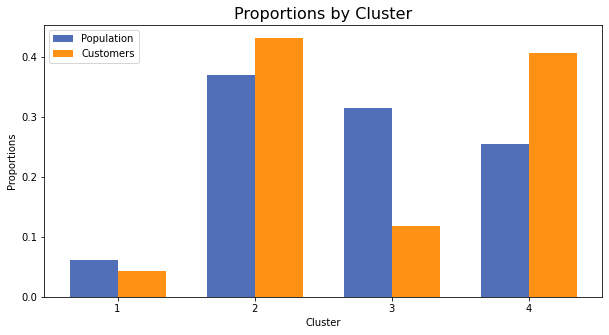

In [16]:
# Plot the clusters proportions
##############################################
# Set the positions and width for the bars
width = 0.35
ind = np.arange(len(clusters_proportions_df['Cluster']))

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

# Create bars for Proportions
p1 = ax.bar(ind - width/2, clusters_proportions_df['Proportion (Population)'], width, label='Population', color='#516FB9')
p2 = ax.bar(ind + width/2, clusters_proportions_df['Proportion (Customers)'], width, label='Customers', color='#FF9114')

# Set labels, title, and legend
ax.set_xlabel('Cluster')
ax.set_ylabel('Proportions')
ax.set_title('Proportions by Cluster',  fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(clusters_proportions_df['Cluster'])
ax.legend()

# Display the plot
plt.show()

In [17]:
# Create a Dataframe with the characteristics of the centroids for each column in the customers dataset
centroids = sc.inverse_transform(pca.inverse_transform(clusterer.cluster_centers_))
df_centroids = pd.DataFrame(centroids, columns = customers_df.keys())
df_centroids = df_centroids.set_index(np.arange(1,len(clusters_proportions_df["Cluster"])+1))
df_centroids

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_STATUS_FEIN,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITA

In [18]:
# Select the clusters of interest and the top 20 identified columns 
top20_columns = ["FINANZ_SPARER", "HH_EINKOMMEN_SCORE", "LP_STATUS_FEIN", "MOBI_REGIO",
                 "ONLINE_AFFINITAET", "OST_WEST_KZ", "PLZ8_ANTG1", "PLZ8_ANTG3", "PLZ8_ANTG4",
                 "PLZ8_BAUMAX", "PLZ8_HHZ", "PRAEGENDE_JUGENDJAHRE", "SEMIO_ERL",
                 "SEMIO_FAM", "SEMIO_KAEM", "SEMIO_KRIT", "SEMIO_KULT", "SEMIO_PFLICHT",
                 "SEMIO_RAT", "SEMIO_TRADV"]

# Add two additional demographic columns to further enrich the analysis
demographic_columns = ["ALTER_HH","CAMEO_DEUG_2015"]

target_columns = top20_columns + demographic_columns

# Create dataframes per target group with the centroid analysis
target_group_1 = df_centroids.loc[4, target_columns]
target_group_2 = df_centroids.loc[2, target_columns]
non_target_group_1 = df_centroids.loc[3, target_columns]
non_target_group_2 = df_centroids.loc[1, target_columns]

# Merge all dataframes together
centroids_by_cluster = pd.concat([target_group_1, target_group_2, non_target_group_1, non_target_group_2], axis=1)
centroids_by_cluster = centroids_by_cluster.rename(columns={4:"Target (C4)", 2:"Target (C2)", 3:"Non-Target (C3)", 1:"Non-Target (C1)"})

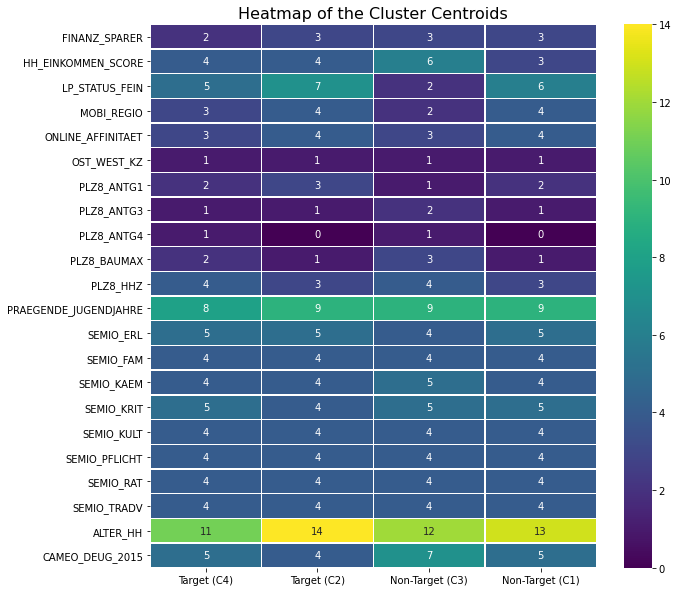

In [19]:
# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(centroids_by_cluster.round(0), cmap='viridis', annot=True, linewidths=.5)
plt.title('Heatmap of the Cluster Centroids', fontsize=16)
plt.show()

# 2. Customer Segmentation Report
This is a part where sometimes data science can be more art than science and it is advisable to have a __domain expert__ involved in this part. Based o the analysis of the previous graphics we can see that the clusters which are overrepresented are clusters 4 and 2. These should be the customer segments the company should put more effort. If focus should be on one segment only, then it should be on `cluster 4` since it has the highest difference in the proportion comparing to the population dataset. On the other side of the coin the company should avoid focusing on the type of customers in `cluster 3`.

__Target customer group 1 (Cluster 4)__

- `FINANZ_SPARER = 2`: high money saver.
- `HH_EINKOMMEN_SCORE = 4`: average estimated household net income.
- `LP_STATUS_FEIN = 5`: minimalistic high-income earners.
- `MOBI_REGIO = 3`: middle mobility pattern.
- `ONLINE_AFFINITAET = 3`: middle online affinity.
- `OST_WEST_KZ = 1`: habitant of the former Western Germany block.
- `PLZ8_ANTG1 = 2`: average number of 1-2 family houses in the PLZ8.
- `PLZ8_ANTG3 = 1`: low number of 6-10 family houses in the PLZ8.
- `PLZ8_ANTG4 = 1`: low number of >10 family houses in the PLZ8.
- `PLZ8_BAUMAX = 2`: most common building-type within the PLZ8 is 3-5 family homes.
- `PLZ8_HHZ = 4`: 600-849 households within the PLZ8.
- `PRAEGENDE_JUGENDJAHRE = 8`: dominating movement in the person's youth: 70ies - family orientation (Mainstream, O+W).
- `SEMIO_ERL = 5`: low affinity indicating in what way the person is eventful orientated.
- `SEMIO_FAM = 4`: average affinity indicating in what way the person is familiar minded.
- `SEMIO_KAEM = 4`: average affinity indicating in what way the person is of a fightfull attitude.
- `SEMIO_KRIT = 5`: low affinity indicating in what way the person is critical minded.
- `SEMIO_KULT = 4`: average affinity indicating in what way the person is cultural minded.
- `SEMIO_PFLICHT = 4`: average affinity indicating in what way the person is dutyfull traditional minded.
- `SEMIO_RAT = 4`: average affinity indicating in what way the person is of a rational mind.
- `SEMIO_TRADV = 4`: average affinity indicating in what way the person is traditional minded.
- `ALTER_HH = 11`: main age within the household: early-70s.
- `CAMEO_DEUG_2015 = 5`: active middleclass.


__Non-Target customer group 1 (Cluster 3)__

- `FINANZ_SPARER = 3`: average money saver.
- `HH_EINKOMMEN_SCORE = 6`: very low estimated household net income.
- `LP_STATUS_FEIN = 2`: orientationseeking low-income earners.
- `MOBI_REGIO = 2`: high mobility pattern.
- `ONLINE_AFFINITAET = 3`: middle online affinity.
- `OST_WEST_KZ = 1`: habitant of the former Western Germany block.
- `PLZ8_ANTG1 = 1`: low number of 1-2 family houses in the PLZ8.
- `PLZ8_ANTG3 = 2`: average number of 6-10 family houses in the PLZ8.
- `PLZ8_ANTG4 = 1`: low number of >10 family houses in the PLZ8.
- `PLZ8_BAUMAX = 3`: most common building-type within the PLZ8 is 6-10 family homes.
- `PLZ8_HHZ = 4`: 600-849 households within the PLZ8.
- `PRAEGENDE_JUGENDJAHRE = 9`: dominating movement in the person's youth: 70ies - peace movement (Avantgarde, O+W).
- `SEMIO_ERL = 4`: average affinity indicating in what way the person is eventful orientated.
- `SEMIO_FAM = 4`: average affinity indicating in what way the person is familiar minded.
- `SEMIO_KAEM = 5`: low affinity indicating in what way the person is of a fightfull attitude.
- `SEMIO_KRIT = 5`: low affinity indicating in what way the person is critical minded.
- `SEMIO_KULT = 4`: average affinity indicating in what way the person is cultural minded.
- `SEMIO_PFLICHT = 4`: average affinity indicating in what way the person is dutyfull traditional minded.
- `SEMIO_RAT = 4`: average affinity indicating in what way the person is of a rational mind.
- `SEMIO_TRADV = 4`: average affinity indicating in what way the person is traditional minded.
- `ALTER_HH = 12`: main age within the household: late-70s.
- `CAMEO_DEUG_2015 = 7`: lower middleclass.


__Final Analysis__:
Looking at both groups we can say that the focus of the campaign efforts should be target on individuals which:
- have recently retired,
- may have earned more than average during their working time and higher amounts of money saved,
- are minimalistic and family-oriented,
- live in denser areas of a (former block) Western German city, but where the majority of households is for smaller families
- and are less willing for attending events.

# 3. Model Deployment

In [20]:
from joblib import dump, load

dump(sc, 'models\\population_scaler.joblib')
dump(pca, 'models\\population_pca.joblib')
dump(clusterer, 'models\\population_clusterer.joblib')

['models\\population_clusterer.joblib']